In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os

## Resize images

In [ ]:
transform = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.ToTensor(),
])

In [ ]:
output_path = "/content/drive/MyDrive/Datasets/Ham10000/ham10000_spilt"
train_dataset = ImageFolder(os.path.join(output_path, "train"), transform= transform)
test_dataset = ImageFolder(os.path.join(output_path, "val"), transform= transform)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

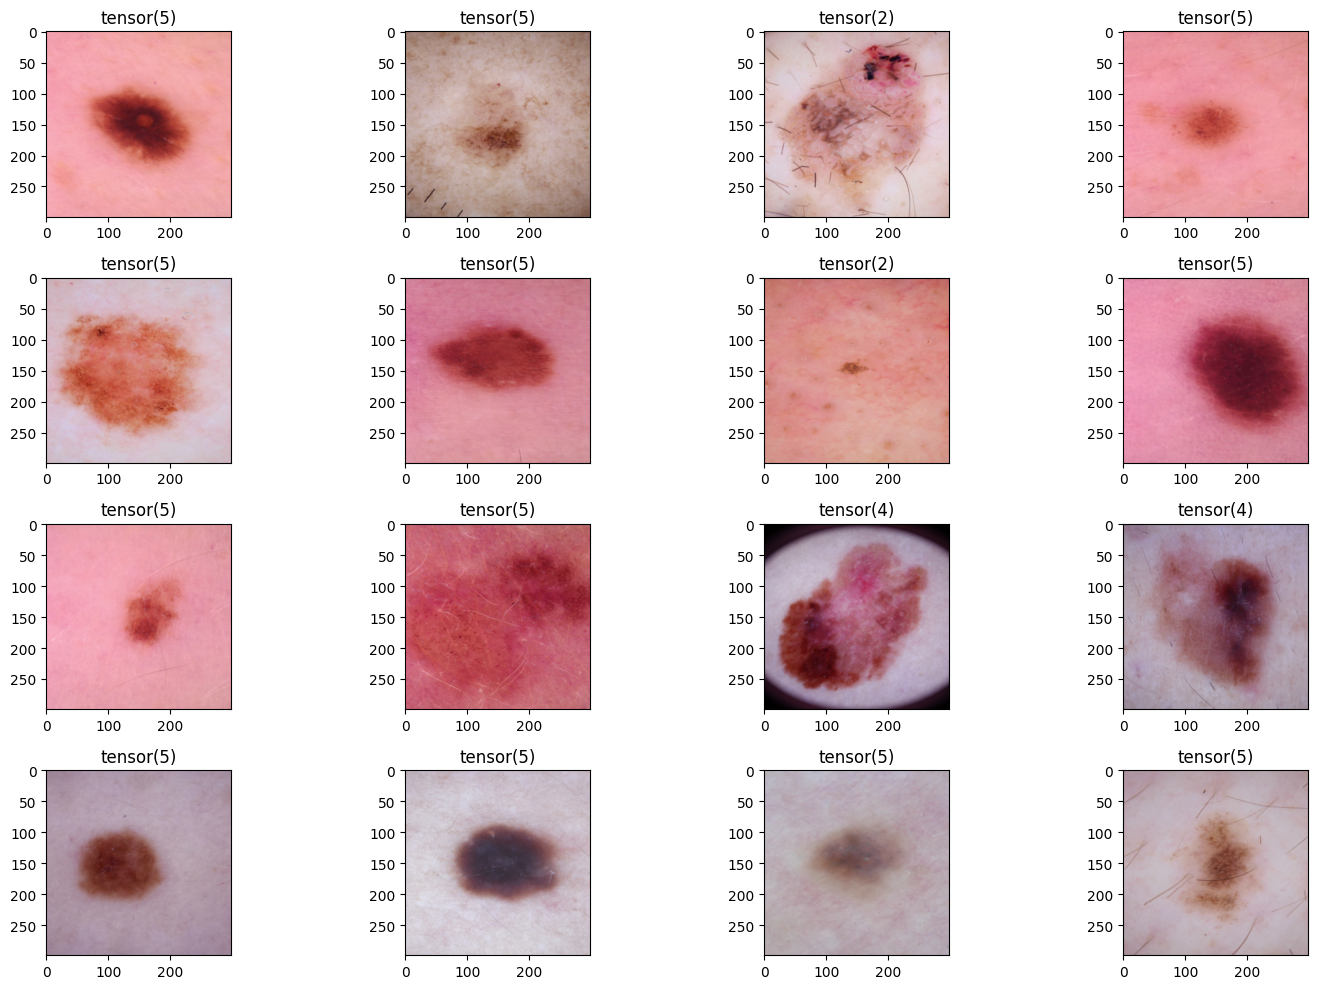

In [ ]:
# Data visualization
plt.figure(figsize=(15,10))
for i,(data, label) in enumerate(train_dataloader):
    for j in range(16):
        plt.subplot(4,4,j+1)
        plt.imshow(data[j].permute(2,1,0))
        plt.title(label[j])
    plt.tight_layout()
    plt.show()
    break

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## First Training

In [ ]:
from torchvision.models import inception_v3
from torchsummary import summary

model = inception_v3(pretrained = False)
model.fc = nn.Linear(2048, 7)
model.to(device)
print(model)
summary(model,input_size=(3,299,299))

epochs = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
from sklearn.metrics import accuracy_score
# Define training process
def evaluate(data_loader):
    loss_all = []
    acc_all = []
    model.eval()
    for i, (data, label) in enumerate(data_loader):
        data = torch.Tensor(data.float()).to(device)
        label = torch.Tensor(label.long()).to(device)

        y_pred = model(data)
        loss = criterion(y_pred, label)
        loss_all.append(loss.item())
        acc = accuracy_score(label.cpu().numpy(), np.array([np.argmax(i) for i in y_pred.detach().cpu().numpy()]))
        acc_all.append(acc)
    return np.mean(np.array(loss_all)), np.mean(np.array(acc_all))

In [ ]:
# First Training
paint_loss_all = []
paint_acc_all = []
paint_val_loss = []
paint_val_acc = []
for epoch in range(epochs):
    loss_all = []
    acc_all = []
    model.train()
    for i, (data, label) in enumerate(train_dataloader):
        data = torch.Tensor(data.float()).to(device)
        label = torch.Tensor(label.long()).to(device)


        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred.logits, label)

        loss.backward()
        optimizer.step()

        loss_all.append(loss.item())
        acc = accuracy_score(label.cpu().numpy(), np.array([np.argmax(i) for i in y_pred.logits.detach().cpu().numpy()]))
        acc_all.append(acc)


    loss_all = np.mean(np.array(loss_all))
    acc_all = np.mean(np.array(acc_all))
    val_loss, val_acc = evaluate(test_dataloader)
    paint_loss_all.append(loss_all), paint_acc_all.append(acc_all), paint_val_loss.append(val_loss), paint_val_acc.append(val_acc)

    print(f"epoch | epochs   {epoch}|{epochs}, loss = {loss_all:.4}   acc = {acc_all:.4}   val_loss = {val_loss:.4}   val_acc = {val_acc:.4}")

epoch | epochs   0|200, loss = 0.9533   acc = 0.6686   val_loss = 0.8159   val_acc = 0.7129
epoch | epochs   1|200, loss = 0.7751   acc = 0.7144   val_loss = 0.8258   val_acc = 0.703
epoch | epochs   2|200, loss = 0.7226   acc = 0.7306   val_loss = 0.7432   val_acc = 0.7135
epoch | epochs   3|200, loss = 0.6994   acc = 0.733   val_loss = 0.7111   val_acc = 0.7398
epoch | epochs   4|200, loss = 0.6709   acc = 0.7482   val_loss = 0.7059   val_acc = 0.7383
epoch | epochs   5|200, loss = 0.655   acc = 0.7533   val_loss = 0.7074   val_acc = 0.7418
epoch | epochs   6|200, loss = 0.6353   acc = 0.7641   val_loss = 0.6949   val_acc = 0.7472
epoch | epochs   7|200, loss = 0.6149   acc = 0.7706   val_loss = 0.7034   val_acc = 0.7529
epoch | epochs   8|200, loss = 0.5942   acc = 0.7802   val_loss = 0.7074   val_acc = 0.7301
epoch | epochs   9|200, loss = 0.5802   acc = 0.781   val_loss = 0.6767   val_acc = 0.7477
epoch | epochs   10|200, loss = 0.5509   acc = 0.7898   val_loss = 0.672   val_acc =

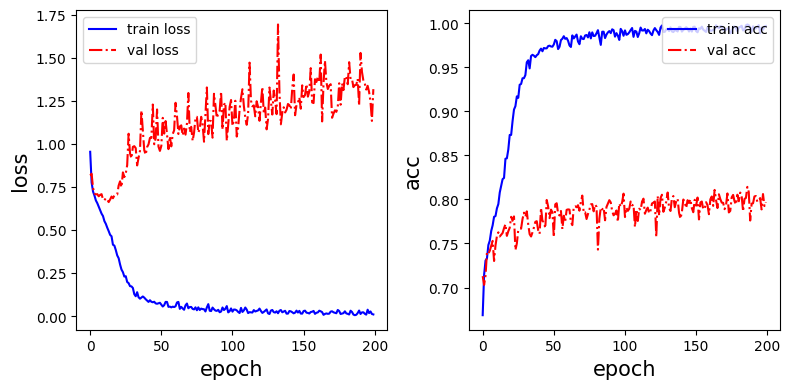

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(paint_loss_all, "b-", label="train loss")
plt.plot(paint_val_loss, "r-.", label="val loss")
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(paint_acc_all, "b-", label="train acc")
plt.plot(paint_val_acc, "r-.", label="val acc")
plt.legend(loc = "upper right")
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("acc", fontsize = 15)
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model, "model.pth")

NameError: name 'model' is not defined

In [ ]:
!pip install scikit-plot

In [ ]:
import scikitplot as skplot

model = torch.load("model.pth")

def plot_roc(data_loader):
    model.eval()
    label_all = []
    y_pred_all = []
    for i, (data, label) in enumerate(data_loader):
        data = torch.Tensor(data.float()).to(device)
        label = torch.Tensor(label.long()).to(device)

        y_pred = model(data)
        label_all.append(label.cpu().numpy())
        y_pred_all.append(y_pred.detach().cpu().numpy())

    skplot.metrics.plot_roc(np.concatenate(np.array(label_all)), np.concatenate(np.array(y_pred_all)))
plot_roc(test_dataloader)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (63,) + inhomogeneous part.

## Second Training

In [ ]:
from torchvision.models import inception_v3
from torchsummary import summary

model = inception_v3(pretrained = False)
model.fc = nn.Linear(2048, 7)
model.to(device)
print(model)
summary(model,input_size=(3,299,299))

epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
from sklearn.metrics import accuracy_score
# Define training process
def evaluate(data_loader):
    loss_all = []
    acc_all = []
    model.eval()
    for i, (data, label) in enumerate(data_loader):
        data = torch.Tensor(data.float()).to(device)
        label = torch.Tensor(label.long()).to(device)

        y_pred = model(data)
        loss = criterion(y_pred, label)
        loss_all.append(loss.item())
        acc = accuracy_score(label.cpu().numpy(), np.array([np.argmax(i) for i in y_pred.detach().cpu().numpy()]))
        acc_all.append(acc)
    return np.mean(np.array(loss_all)), np.mean(np.array(acc_all))

In [ ]:
# Training
paint_loss_all = []
paint_acc_all = []
paint_val_loss = []
paint_val_acc = []
for epoch in range(epochs):
    loss_all = []
    acc_all = []
    model.train()
    for i, (data, label) in enumerate(train_dataloader):
        data = torch.Tensor(data.float()).to(device)
        label = torch.Tensor(label.long()).to(device)


        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred.logits, label)

        loss.backward()
        optimizer.step()

        loss_all.append(loss.item())
        acc = accuracy_score(label.cpu().numpy(), np.array([np.argmax(i) for i in y_pred.logits.detach().cpu().numpy()]))
        acc_all.append(acc)


    loss_all = np.mean(np.array(loss_all))
    acc_all = np.mean(np.array(acc_all))
    val_loss, val_acc = evaluate(test_dataloader)
    paint_loss_all.append(loss_all), paint_acc_all.append(acc_all), paint_val_loss.append(val_loss), paint_val_acc.append(val_acc)

    print(f"epoch | epochs   {epoch}|{epochs}, loss = {loss_all:.4}   acc = {acc_all:.4}   val_loss = {val_loss:.4}   val_acc = {val_acc:.4}")

epoch | epochs   0|50, loss = 0.9257   acc = 0.6805   val_loss = 0.8044   val_acc = 0.7132
epoch | epochs   1|50, loss = 0.7813   acc = 0.7112   val_loss = 0.7579   val_acc = 0.716
epoch | epochs   2|50, loss = 0.7215   acc = 0.7319   val_loss = 0.7274   val_acc = 0.7346
epoch | epochs   3|50, loss = 0.6922   acc = 0.7383   val_loss = 0.7523   val_acc = 0.7326
epoch | epochs   4|50, loss = 0.6785   acc = 0.7434   val_loss = 0.7352   val_acc = 0.7375
epoch | epochs   5|50, loss = 0.6472   acc = 0.7592   val_loss = 0.7245   val_acc = 0.7343
epoch | epochs   6|50, loss = 0.6296   acc = 0.7644   val_loss = 0.6963   val_acc = 0.7559
epoch | epochs   7|50, loss = 0.6098   acc = 0.7732   val_loss = 0.6776   val_acc = 0.748
epoch | epochs   8|50, loss = 0.5876   acc = 0.7809   val_loss = 0.6929   val_acc = 0.7611
epoch | epochs   9|50, loss = 0.5736   acc = 0.7866   val_loss = 0.6389   val_acc = 0.7534
epoch | epochs   10|50, loss = 0.5433   acc = 0.7928   val_loss = 0.6577   val_acc = 0.7469


In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.plot(paint_loss_all, "b-", label="train loss")
plt.plot(paint_val_loss, "r-.", label="val loss")
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("loss", fontsize = 15)
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.plot(paint_acc_all, "b-", label="train acc")
plt.plot(paint_val_acc, "r-.", label="val acc")
plt.legend(loc = "upper right")
plt.xlabel("epoch", fontsize = 15)
plt.ylabel("acc", fontsize = 15)
plt.tight_layout()
plt.show()